In [1]:
library(SBC);
library(cmdstanr);
library(jsonlite);
library(tidyverse);
options(mc.cores = parallel::detectCores());
library(future);
plan(multisession);

options(SBC.min_chunk_size = 5);

cache_dir <- "./SBC_cache"
if(!dir.exists(cache_dir)) {
    dir.create(cache_dir)
}

ALPHA <- 0.05
model_Poisson_v2 <- cmdstanr::cmdstan_model("../models/Poisson_model_v2.stan")
model_Poisson_v2_real_data <- cmdstanr::cmdstan_model("../models/Poisson_model_v2_real_data.stan")

This is cmdstanr version 0.7.1

- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr

- CmdStan path: /Users/igor.michels/.cmdstan/cmdstan-2.34.1

- CmdStan version: 2.34.1


A newer version of CmdStan is available. See ?install_cmdstan() to install it.
To disable this check set option or environment variable CMDSTANR_NO_VER_CHECK=TRUE.

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.0     v tibble    3.2.1
v lubridate 1.9.3     v tidyr     1.3.1
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter()  masks stats::filter()
x purrr::flatten() masks jsonlite::flatten()
x dplyr::lag()     masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message in readLines(stan_file):
"linha final incompleta encontrada em '.

In [2]:
N_SIMS <- 100
N_CLUBS <- 20
N_ITER_WARMUP <- 200
N_ITER_SAMPLING <- 1000
N_CHAINS <- 4

In [3]:
data_generator_single_Poisson_v2 <- function(n_clubs, n_players_per_clubs){
    n_seasons <- 1
    clubs <- 1:n_clubs
    force <- c(abs(rnorm(1, mean=1, sd=1e-4)))
    while (length(force) != length(clubs) * n_players_per_clubs) {
        new_force <- rnorm(1, mean=1, sd=1)
        if (new_force > 0) {
            force <- c(force, new_force)
        }
    }

    df <- data.frame(Club = clubs)
    data <- merge(df, df, by = NULL) %>% filter(Club.x != Club.y)
    data <- data %>% slice(rep(row_number(), n_seasons))
    home_goals <- list()
    away_goals <- list()
    home_players <- array(NA, dim = c(nrow(data), 11))
    away_players <- array(NA, dim = c(nrow(data), 11))
    players <- seq(1, n_players_per_clubs)
    for (i in 1:nrow(data)) {
        home_team <- data[i, 1]
        away_team <- data[i, 2]
        home_players_game <- n_players_per_clubs * (home_team - 1) + sample(players)[1:11]
        away_players_game <- n_players_per_clubs * (away_team - 1) + sample(players)[1:11]
        home_force <- sum(force[home_players_game])
        away_force <- sum(force[away_players_game])
        home_goals <- append(home_goals, rpois(1, home_force / away_force))
        away_goals <- append(away_goals, rpois(1, away_force / home_force))
        home_players[i,] <- home_players_game
        away_players[i,] <- home_players_game
    }

    data$home.goals <- home_goals
    data$away.goals <- away_goals
    names(data) <- c("home_name", "away_name", "home_goals", "away_goals")

    list(
        variables = list(
            skills = force
        ),
        generated = list(
            n_games = nrow(data),
            n_teams = n_clubs,
            n_players = n_clubs * n_players_per_clubs,
            total_time_per_game = 90,
            home_team = data$home_name,
            away_team = data$away_name,
            home_score = data$home_goals,
            away_score = data$away_goals,
            home_players = home_players,
            away_players = away_players,
            time_played = rep(90, nrow(data))
        )
    )
}

In [4]:
run_model <- function(n_players_per_clubs){
    set.seed(0)
    data_generator_Poisson_v2 <- SBC_generator_function(data_generator_single_Poisson_v2, n_clubs = N_CLUBS,
                                                        n_players_per_clubs = n_players_per_clubs)

    dataset_Poisson_v2 <- generate_datasets(data_generator_Poisson_v2, N_SIMS)
    
    # max_rank will be iter_sampling * chains / 10 - 1
    backend_Poisson_v2 <- SBC_backend_cmdstan_sample(model_Poisson_v2, iter_warmup = N_ITER_WARMUP,
                                                     iter_sampling = N_ITER_SAMPLING, chains = N_CHAINS)

    results_Poisson_v2 <- compute_SBC(dataset_Poisson_v2, backend_Poisson_v2,
                                      keep_fits = FALSE,
                                      cache_mode = "results",
                                      cache_location = file.path(cache_dir,
                                                                 sprintf("results_Poisson_v2_%02d_players_per_club",
                                                                         n_players_per_clubs)))
    
    write.csv(results_Poisson_v2$stats,
              file = sprintf("SBC_cache/results_Poisson_v2_%02d_players_per_club_stats.csv",
                             n_players_per_clubs))
    
    results_Poisson_v2
}

In [5]:
all_results <- list()
# for (n_players_per_clubs in c(11:20, 36)) {
for (n_players_per_clubs in c(36)) {
    results <- run_model(n_players_per_clubs)

    graph <- plot_ecdf(results)
    plot_data <- ggplot_build(graph)$data
    confidence_interval <- plot_data[[1]]
    ecdf <- plot_data[[2]]

    df1 <- merge(select(confidence_interval, - c(colour, fill, group, flipped_aes, linewidth, linetype, alpha, y)),
                 select(ecdf, - c(colour, fill, group, linewidth, linetype, alpha)),
                 by = c("PANEL", "x"), all.x = TRUE) %>%
        group_by(PANEL, x) %>%
        summarize(ymax = max(ymax, na.rm = TRUE),
                  ymin = max(ymin, na.rm = TRUE),
                  y = max(y, na.rm = TRUE))

    df1$out <- (df1$ymax < df1$y) + (df1$ymin > df1$y)
    df1 <- df1 %>% group_by(PANEL) %>% summarise(out_ratio = sum(out), .groups = 'keep')
    df1$out_ratio <- df1$out_ratio / length(unique(ecdf$x))
    df1$out <- df1$out_ratio > ALPHA

    graph <- plot_ecdf_diff(results)
    plot_data <- ggplot_build(graph)$data
    confidence_interval <- plot_data[[1]]
    ecdf <- plot_data[[2]]

    df2 <- merge(select(confidence_interval, - c(colour, fill, group, flipped_aes, linewidth, linetype, alpha, y)),
                 select(ecdf, - c(colour, fill, group, linewidth, linetype, alpha)),
                 by = c("PANEL", "x"), all.x = TRUE) %>%
        group_by(PANEL, x) %>%
        summarize(ymax = max(ymax, na.rm = TRUE),
                  ymin = max(ymin, na.rm = TRUE),
                  y = max(y, na.rm = TRUE))

    df2$out <- (df2$ymax < df2$y) + (df2$ymin > df2$y)
    df2 <- df2 %>% group_by(PANEL) %>% summarise(out_ratio = sum(out), .groups = 'keep')
    df2$out_ratio <- df2$out_ratio / length(unique(ecdf$x))
    df2$out <- df2$out_ratio > ALPHA

    final_df <- merge(df1, df2, by = "PANEL", suffixes = c("", "_diff"))
    key <- paste0(n_players_per_clubs, "_players")
    all_results[[key]] <- c(mean(as.numeric(final_df$out)), mean(as.numeric(final_df$out_diff)))
}

Results loaded from cache file 'results_Poisson_v2_36_players_per_club'

 - 73 (73%) fits had at least one Rhat > 1.01. Largest Rhat was 2.88.

 - 69 (69%) fits had tail ESS undefined or less than half of the maximum rank, potentially skewing 
the rank statistics. The lowest tail ESS was 11.
 If the fits look good otherwise, increasing `thin_ranks` (via recompute_SBC_statistics) 
or number of posterior draws (by refitting) might help.

 - 7 (7%) fits had divergent transitions. Maximum number of divergences was 4.

 - 100 (100%) fits had iterations that saturated max treedepth. Maximum number of max treedepth was 2393.

Not all diagnostics are OK.
You can learn more by inspecting $default_diagnostics, $backend_diagnostics 
and/or investigating $outputs/$messages/$warnings for detailed output from the backend.

`summarise()` has grouped output by 'PANEL'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'PANEL'. You can override using the
`.groups` argum

In [6]:
print(all_results)

$`36_players`
[1] 0.01250000 0.01944444



Results loaded from cache file 'results_Poisson_v2_36_players_per_club'

 - 73 (73%) fits had at least one Rhat > 1.01. Largest Rhat was 2.88.

 - 69 (69%) fits had tail ESS undefined or less than half of the maximum rank, potentially skewing 
the rank statistics. The lowest tail ESS was 11.
 If the fits look good otherwise, increasing `thin_ranks` (via recompute_SBC_statistics) 
or number of posterior draws (by refitting) might help.

 - 7 (7%) fits had divergent transitions. Maximum number of divergences was 4.

 - 100 (100%) fits had iterations that saturated max treedepth. Maximum number of max treedepth was 2393.

Not all diagnostics are OK.
You can learn more by inspecting $default_diagnostics, $backend_diagnostics 
and/or investigating $outputs/$messages/$warnings for detailed output from the backend.



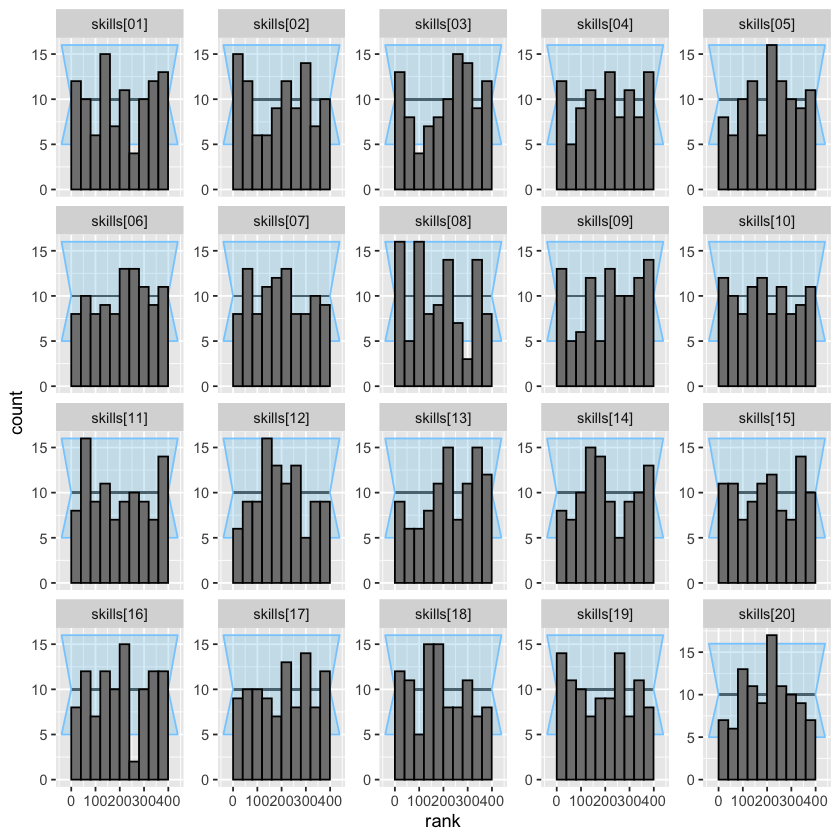

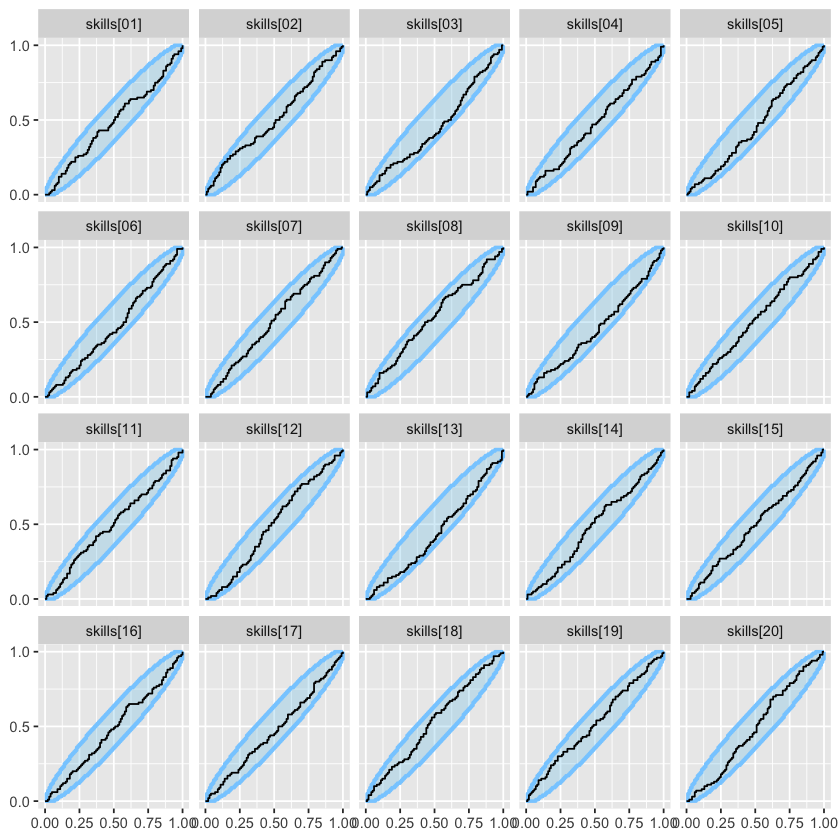

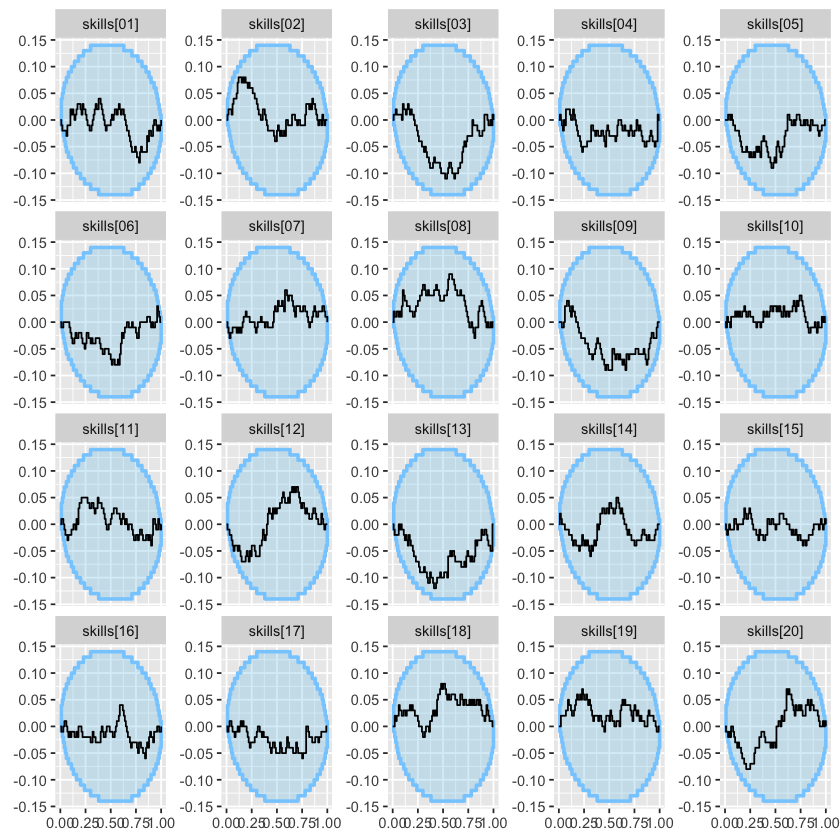

In [7]:
results <- run_model(36)
filtered_results <- results[["stats"]] %>% filter(variable %in% paste0("skills[", 1:20, "]"))
filtered_results$variable <- paste0("skills[", sprintf("%02d", as.numeric(gsub("skills\\[(\\d+)\\]", "\\1", filtered_results$variable))), "]")
plot_rank_hist(filtered_results)
plot_ecdf(filtered_results) + theme(legend.position = "none")
plot_ecdf_diff(filtered_results) + theme(legend.position = "none")

In [8]:
run_model <- function(min_year, max_year=NULL) {
    if (is.null(max_year)) max_year <- min_year

    if (min_year == max_year) {
        output_path <- paste0("../results/results_Poisson_with_players_", min_year, ".csv")
        input_path <- paste0('../real_data/Poisson_with_players_model_data_', min_year, '.json')
    } else {
        output_path <- paste0("../results/results_Poisson_with_players_", min_year, "_to_", max_year, ".csv")
        input_path <- paste0('../real_data/Poisson_with_players_model_data_', min_year, '_to_', max_year, '.json')
    }

    if (!file.exists(output_path)) {
        data <- read_json(input_path)
        data[["teams"]] <- NULL
        data[["players"]] <- NULL
        
        for (i in 1:length(data$home_players)) {
            if (length(data$home_players[[i]]) != 11) {
                while (length(data$home_players[[i]]) < 11) {
                    data$home_players[[i]] <- c(data$home_players[[i]], data$n_players + 1)
                }
            }
            if (length(data$away_players[[i]]) != 11) {
                while (length(data$away_players[[i]]) < 11) {
                    data$away_players[[i]] <- c(data$away_players[[i]], data$n_players + 1)
                }
            }
        }

        stan_data <- list(
            n_games = data$n_games,
            n_teams = data$n_teams,
            n_players = data$n_players,
            total_time_per_game = data$total_time_per_game,
            home_team = unlist(data$home_team),
            away_team = unlist(data$away_team),
            home_score = unlist(data$home_score),
            away_score = unlist(data$away_score),
            home_players = matrix(unlist(data$home_players), nrow=data$n_games, ncol=11, byrow=TRUE),
            away_players = matrix(unlist(data$away_players), nrow=data$n_games, ncol=11, byrow=TRUE),
            time_played = unlist(data$time_played)
        )
        
        capture.output({
            fit <- suppressMessages(
                suppressWarnings(
                    model_Poisson_v2_real_data$sample(
                        data = stan_data,
                        chains = N_CHAINS,
                        parallel_chains = N_CHAINS,
                        refresh = 500
                    )
                )
            )
        })

        results <- fit$summary(
            variables = NULL,
            posterior::default_summary_measures(),
            extra_quantiles = ~posterior::quantile2(., probs = c(.0275, .975))
        )

        write.csv(results, file = output_path, row.names = FALSE)
    }
}

In [9]:
for (year in 2019:2023) {
    run_model(year)
    message(paste("Completed processing for year", year))
}

run_model(2019, 2023)
run_model(2014, 2023)

Completed processing for year 2019

Completed processing for year 2020

Completed processing for year 2021

Completed processing for year 2022

Completed processing for year 2023

